In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
sns.set(font_scale=2)

import pandas as pd

from sklearn.linear_model import HuberRegressor, LinearRegression, BayesianRidge

In [2]:
sns.set(context='paper', style="whitegrid", font_scale=3, font = 'serif')

%matplotlib inline
linewidth = 2

# Energy resolution on random graph

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer
def energy_resolution_metric(y_true, y_pred):
    return np.std((y_true - y_pred) / y_true)
energy_resolution_score = make_scorer(energy_resolution_metric, greater_is_better=False)

In [4]:
def get_data(E_raw, z, E_true, experiment = '.npy'):
    #E_raw, E_true -- .npy files

    E_raw_test = np.load(E_raw + 'test' + experiment)
    E_raw_val = np.load(E_raw + 'test' + experiment)
    
    E_true_test = np.load(E_true + 'test' + experiment)
    E_true_val = np.load(E_true + 'test' + experiment)
    
    z_test = np.load(z + 'test' + experiment)
    z_val = np.load(z + 'test' + experiment)
    
    assert(len(E_raw_test)==len(E_true_test))
    
    X_test, X_val = np.vstack([E_raw_test, z_test]).T, np.vstack([E_raw_val, z_val]).T
    
    return X_test, X_val, E_true_test, E_true_val

## Using a quantile transformation to evenly slide the window through the energies 

In [33]:
E_true_val = np.load('E_true_200_test.npy')

In [34]:
E_pred_val = np.load('E_pred_200_test.npy')

In [35]:
z_val = np.load('z_200_test.npy')

In [36]:
len(E_pred_val)==len(E_true_val)==len(z_val)

True

In [37]:
len(z_val)

526

In [38]:
len(E_pred_val)

526

In [39]:
sum(E_pred_val <= 10)

0

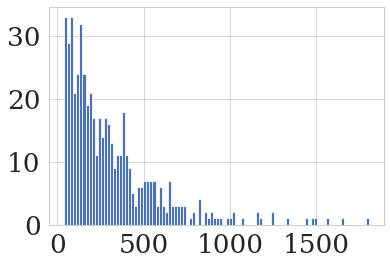

In [40]:
plt.hist(E_pred_val, bins = 100);

Text(0.5, 0, 'True Energy')

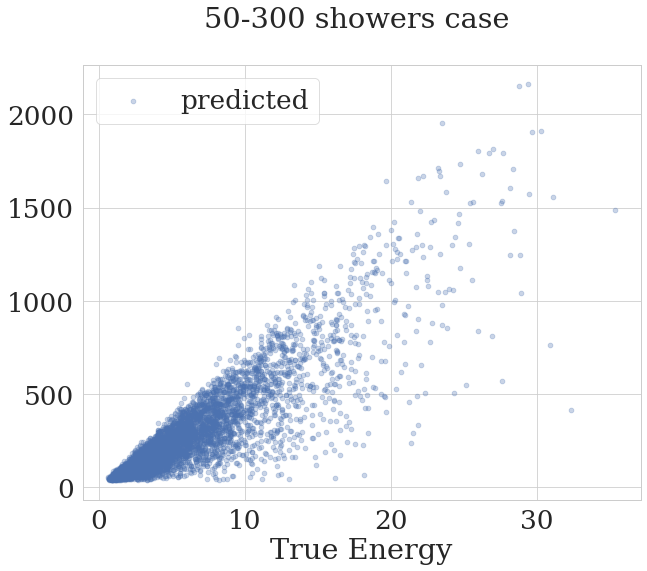

In [13]:
plt.figure(figsize =(10,8))

plt.scatter(E_true_val, E_pred_val, alpha=0.3, label = 'predicted')

plt.legend()
plt.title("50-300 showers case \n")
plt.xlabel('True Energy')

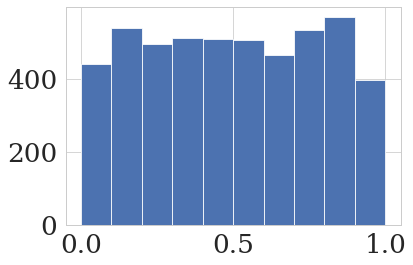

In [14]:
qt = QuantileTransformer(n_quantiles=10, random_state=0)
plt.hist(qt.fit_transform(np.log(E_true_val).reshape(-1, 1)).reshape(-1));

In [15]:
def rolling_window_er(x, y, window=0.1, step=10):
    step = window / step
    start = x.min()
    end = x.max()
    # step back a little from the edges so that there are no edge effects due to low statistics 
    x_lin = np.arange(start + window / 3, end - window / 3, step=step)
    y_lin = []
    for current_center in x_lin:
        # count ER bit by bit with the center at current_center and span = window
        idx = (x < current_center + window / 2) & (x > current_center - window / 2)
        y_lin.append(y[idx].std())
    return x_lin, np.array(y_lin)

In [16]:
def predict_er(X_test, E_test, X, E, window=0.21, step=10, q=20, use_box_cox=False):
    qt = QuantileTransformer(n_quantiles=q, random_state=0)

    lr = HuberRegressor()
    lr.fit(X_test, E_test)

    E_pred = lr.predict(X)
    idx_sorted = np.argsort(E)
    X = X[idx_sorted]
    E_pred = E_pred[idx_sorted]
    E = E[idx_sorted]
    
    # use box-cox + quantile transformation so that the data lies uniformly in the interval [0, 1] 
    if use_box_cox:
        E_quantile = qt.fit_transform(np.log(E).reshape(-1, 1)).reshape(-1)
    else:
        E_quantile = qt.fit_transform(E.reshape(-1, 1)).reshape(-1)
    
    E_pred = lr.predict(X)
    x, y = rolling_window_er(E_quantile, (E - E_pred) / E, window=window, step=step)
    if use_box_cox:
        x = np.exp(qt.inverse_transform(x.reshape(-1, 1)).reshape(-1))
    else:
        x = qt.inverse_transform(x.reshape(-1, 1)).reshape(-1)
        
        
    return x, y

def generate_bootstrap_data(X_test, E_test, X, E, boot=100, window=0.1, step=10, q=20, use_box_cox=False):
    E_true_boot = []
    ER_boot = []
    qt = QuantileTransformer(n_quantiles=q, random_state=0)

    for i in range(boot):
        boot_idx = np.random.randint(low=0, high=len(X), size=len(X))
        X_boot = X[boot_idx]
        E_boot = E[boot_idx]
        x, y = predict_er(X_test, E_test, X_boot, E_boot, window=window, step=step, q=q, use_box_cox=use_box_cox)
        E_true_boot.append(x)
        ER_boot.append(y)

    E_true_boot = np.array(E_true_boot)
    ER_boot = np.array(ER_boot)
    return E_true_boot, ER_boot

## Checking Bayes Variance to Choose the Optimal Window Size 

In [17]:
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

In [18]:
def window_estimate(X_test, E_test, X, E):
    # low-bias estimate approximation
    _, ER_full_low_bias = predict_er(X_test, E_test, X, E, window=0.01, step=10, q=5, use_box_cox=True)
    # NaN treating
    NaN = ER_full_low_bias[np.where(ER_full_low_bias > 0)[0][-1]]
    ER_full_low_bias[~(ER_full_low_bias > 0)] = NaN

    windows = np.logspace(-2, -0.3, 40)
    bias = []
    variance = []

    for window in windows:
        E_true_boot, ER_boot = generate_bootstrap_data(X_test, E_test, X, E, boot=1000, window=window, step=10, q=5, use_box_cox=True)
        ER_boot[~(ER_boot > 0)] = NaN
        variance.append((ER_boot.std(axis=0)**2).mean())
        bias.append(np.mean((ER_boot - signal.resample(ER_full_low_bias, ER_boot.shape[1]))**2))

    resulted_window = np.round(windows[np.argmin(np.array(variance) + np.array(bias))],2)        
    return resulted_window

## Enargy Resolution for different graphs configurations 

In [19]:
E_RAW = ['E_pred_rand_', 'E_pred_200_',
         'E_pred_50_','E_pred_1_']

In [20]:
Z_coordinates = ['z_rand_', 'z_200_',
         'z_50_', 'z_1_']

In [21]:
E_TRUE = ['E_true_rand_', 'E_true_200_',
          'E_true_50_', 'E_true_1_']

In [22]:
NAME = ['50-300 showers',  '200 showers', '50 showers', '1 shower']

In [23]:
colors = ['lightcoral', 'sandybrown',  'cornflowerblue', 'slateblue',  'cornsilk']

In [24]:
colors_ = [ 'firebrick',  'darkorange',   'royalblue', 'darkslateblue', 'gold', 'darkorange']

-----

In [25]:
def plot_ER(E_RAW, E_TRUE, NAME, colors, colors_,  use_box_cox=True, experiment = '.npy'):
    
    plt.figure(figsize=(12, 8), dpi=100)
    
    #X_test_1, X_val_1, E_true_test_1, E_true_val_1 = get_data(E_RAW[1], Z_coordinates[1], 
    #                                                      E_TRUE[1], experiment)
        
    #window = window_estimate(X_test_1, E_true_test_1, X_val_1, E_true_val_1)
    #print(window)
        
    window = 0.21
    
    for i in range(len(E_RAW)):
        
        print(i)
        
        X_test, X_val, E_true_test, E_true_val = get_data(E_RAW[i], Z_coordinates[i], 
                                                          E_TRUE[i], experiment)
        
        
        E_true_full, ER_full = predict_er(X_test, E_true_test, X_val, E_true_val, 
                                          window=window, q=5, use_box_cox=use_box_cox)
        E_true_boot, ER_boot = generate_bootstrap_data(X_test, E_true_test, X_val, E_true_val, boot=100, 
                                                       window=window, q=5, use_box_cox=use_box_cox)

        lower, upper = np.percentile(ER_boot, [2.5, 97.5], axis=0)
        E_true_mean = E_true_boot.mean(axis=0) 
        ER_mean = ER_boot.mean(axis=0)

        plt.plot(E_true_mean, upper, colors[i], E_true_mean, lower, colors[i], alpha=0.6,  linewidth=2);
        plt.plot(E_true_boot.T, ER_boot.T, c=colors[i], alpha=0.02);
        plt.plot(E_true_mean, ER_mean, c=colors_[i], alpha=0.6, linewidth=2, label=NAME[i])
        plt.plot(E_true_full, ER_full, c=colors[i], alpha=0.4, linewidth=2)


    plt.xlabel("True energy (GeV)")
    plt.ylabel("Mean ER")
    
    leg = plt.legend()

    #for line in leg.get_lines():
    #    line.set_linewidth(2.0)
        
    #plt.legend()

    plt.savefig("ER_comparison.pdf", bbox_inches='tight')
    plt.show()


0
1
2
3


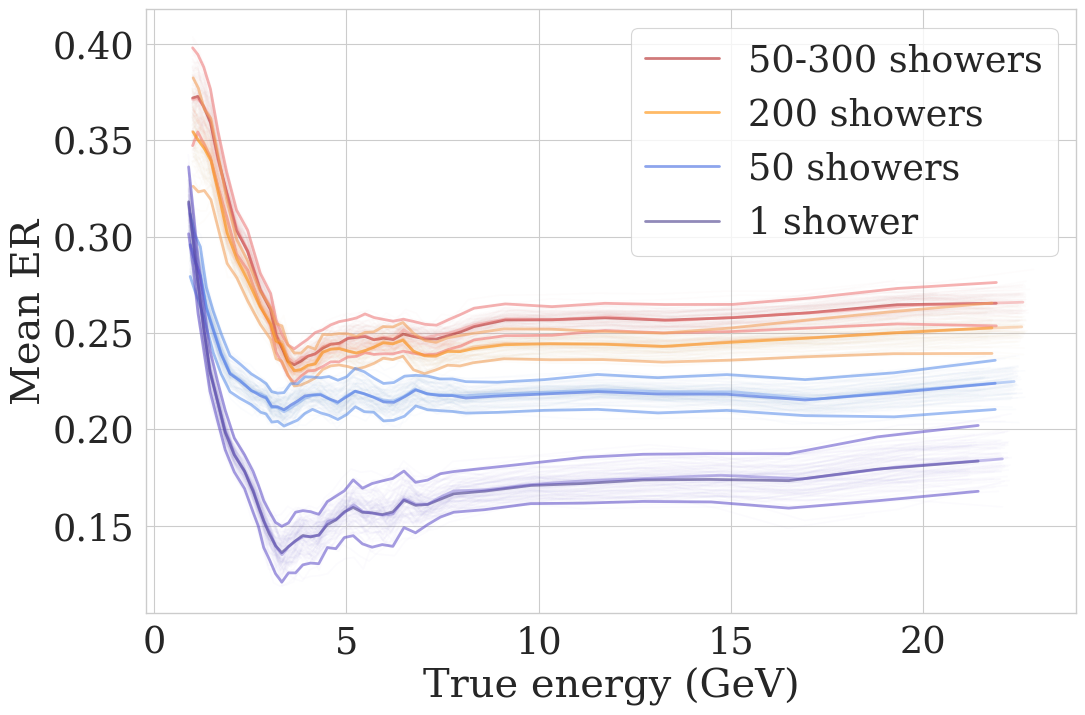

In [26]:
plot_ER(E_RAW, E_TRUE, NAME, colors, colors_, use_box_cox=True, experiment = '_2.npy')

In [27]:
def get_data_2(E_raw, z, E_true):
    #E_raw, E_true -- .npy files

    E_raw = np.load(E_raw)
   
    E_true = np.load(E_true)
    
    z = np.load(z)
    
    X = np.vstack([E_raw, z]).T
    
    return X, E_true

In [29]:
window = 0.21
use_box_cox = True
i = 0

In [30]:
X_test, X_val, E_true_test, E_true_val = get_data(E_RAW[0], Z_coordinates[0], 
                                                          E_TRUE[0], '_2.npy')
        

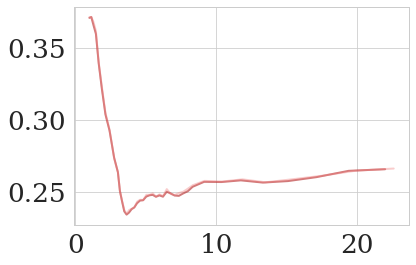

In [31]:
E_true_full, ER_full = predict_er(X_test, E_true_test, X_val, E_true_val, 
                                  window=window, q=5, use_box_cox=use_box_cox)
E_true_boot, ER_boot = generate_bootstrap_data(X_test, E_true_test, X_val, E_true_val, boot=100, 
                                                       window=window, q=5, use_box_cox=use_box_cox)

lower, upper = np.percentile(ER_boot, [2.5, 97.5], axis=0)
E_true_mean = E_true_boot.mean(axis=0) 
ER_mean = ER_boot.mean(axis=0)

#plt.plot(E_true_mean, upper, colors[i], E_true_mean, lower, colors[i], alpha=0.6,  linewidth=2);
#plt.plot(E_true_boot.T, ER_boot.T, c=colors[i], alpha=0.02);
plt.plot(E_true_mean, ER_mean, c=colors_[i], alpha=0.6, linewidth=2, label=NAME[i])
plt.plot(E_true_full, ER_full, c=colors[i], alpha=0.4, linewidth=2)

In [32]:
np.mean(ER_full)

0.26825641600725786

In [30]:
qt = QuantileTransformer(n_quantiles=5, random_state=0)

lr = HuberRegressor()
lr.fit(X_test, E_true_test)

E_pred = lr.predict(X_val)
idx_sorted = np.argsort(E_true_val)
X_val = X_val[idx_sorted]
E_pred = E_pred[idx_sorted]
E = E_true_val[idx_sorted]
    
    # use box-cox + quantile transformation so that the data lies uniformly in the interval [0, 1] 
if use_box_cox:
    E_quantile = qt.fit_transform(np.log(E).reshape(-1, 1)).reshape(-1)
else:
    E_quantile = qt.fit_transform(E.reshape(-1, 1)).reshape(-1)
    
E_pred = lr.predict(X_val)

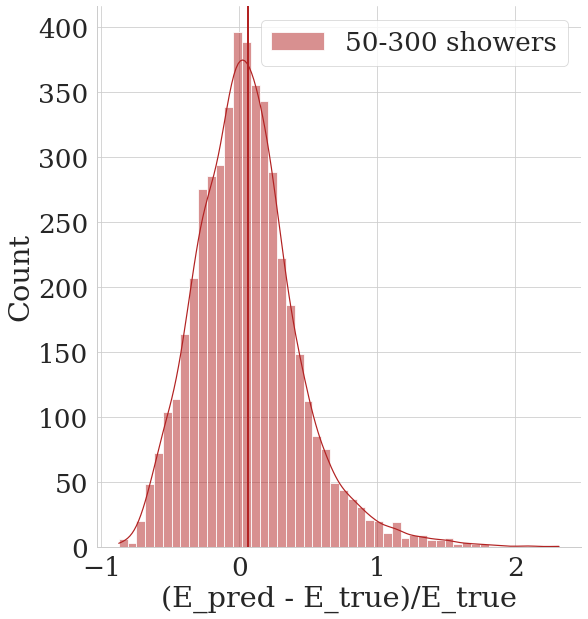

In [43]:
sns.displot((E_pred-E)/E, bins = 50, kde =True, height=8.27, label = '50-300 showers', color = 'firebrick');
plt.xlabel('(E_pred - E_true)/E_true')
leg = plt.legend()
plt.axvline(np.mean((E_pred-E)/E), color = 'firebrick', linewidth=2);
plt.savefig("E_estimation.pdf", bbox_inches='tight')

